## This jupyter notebook will take cell coordinates and plot cells color-coded by niches & interfaces 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#load the data 
data = pd.read_csv('./lukas_data/7n_output/cells_niches_coordinates_interfaces.csv')

#specify niche & interface columns 
niche_columns = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']
intf_columns = ['a1a2', 'a1a3', 'a1a4', 'a1a5', 'a1a6', 'a1a7', 'a2a3', 'a2a4', 'a2a5', 'a2a6', 'a2a7', 'a3a4', 'a3a5', 'a3a6', 'a3a7', 'a4a5', 'a4a6', 'a4a7', 'a5a6', 'a5a7', 'a6a7']


#use row max to determine the highest niche weight for each cell & allocate the niche with the max weight to this cell 
data['niche'] = data[niche_columns].idxmax(axis=1)

data['interface'] = data[intf_columns].idxmax(axis=1)

data['max_interface_value'] = data[intf_columns].max(axis=1)

#reorder columna 
new_column_order = ['niche', 'interface', 'max_interface_value', 'SampleID', 'cell_id', 'cell_type', 'x', 'y']
data = data[new_column_order]

#count cell type frequencies per niche 
niche_counts = data.groupby('niche')['cell_type'].value_counts().unstack(fill_value=0)

phenotype_counts_niches = pd.DataFrame(niche_counts)

interface_counts = data.groupby('interface')['cell_type'].value_counts().unstack(fill_value=0)

phenotype_counts_interfaces = pd.DataFrame(interface_counts)

niches_interfaces = [phenotype_counts_niches, phenotype_counts_interfaces]

result3 = pd.concat(niches_interfaces)

#transpose the dataframe 
result_transposed3 = result3.T

columns_to_normalise3 = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a1a2', 'a1a3', 'a1a4', 'a1a5', 'a1a6', 'a1a7', 'a2a3', 'a2a4', 'a2a5', 'a2a6', 'a2a7', 'a3a4', 'a3a5', 'a3a6', 'a3a7', 'a4a5', 'a4a6', 'a4a7', 'a5a6', 'a5a7', 'a6a7']  # Specify the columns you want to normalize

#normalise each column to sum to 1
result_normalised3 = result_transposed3[columns_to_normalise3].div(result_transposed3[columns_to_normalise3].sum(axis=0), axis=1)

#visualise the normalised result 
#result_normalised3.style.background_gradient(cmap='viridis').set_properties(**{'font-size': '20px'})

print(data)

       niche interface  max_interface_value  SampleID  cell_id  \
0         a5      a2a5             0.078392         1       92   
1         a7      a5a7             0.085460         1       95   
2         a7      a5a7             0.130556         1       97   
3         a7      a2a7             0.119901         1      101   
4         a2      a2a5             0.058911         1      102   
...      ...       ...                  ...       ...      ...   
915980    a7      a2a7             0.105375       154     8493   
915981    a5      a3a5             0.082242       154     8494   
915982    a2      a2a5             0.089402       154     8495   
915983    a5      a3a5             0.150543       154     8496   
915984    a3      a2a3             0.152878       154     8497   

                    cell_type           x           y  
0       Macrophages/Monocytes  260.137931   26.620690  
1                        MPO+  266.057692   26.519231  
2                        MPO+  276.6666

/var/folders/qd/h1rn231d183b1vyz69l8c9440000gn/T/ipykernel_14789/672628188.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("Greys"),


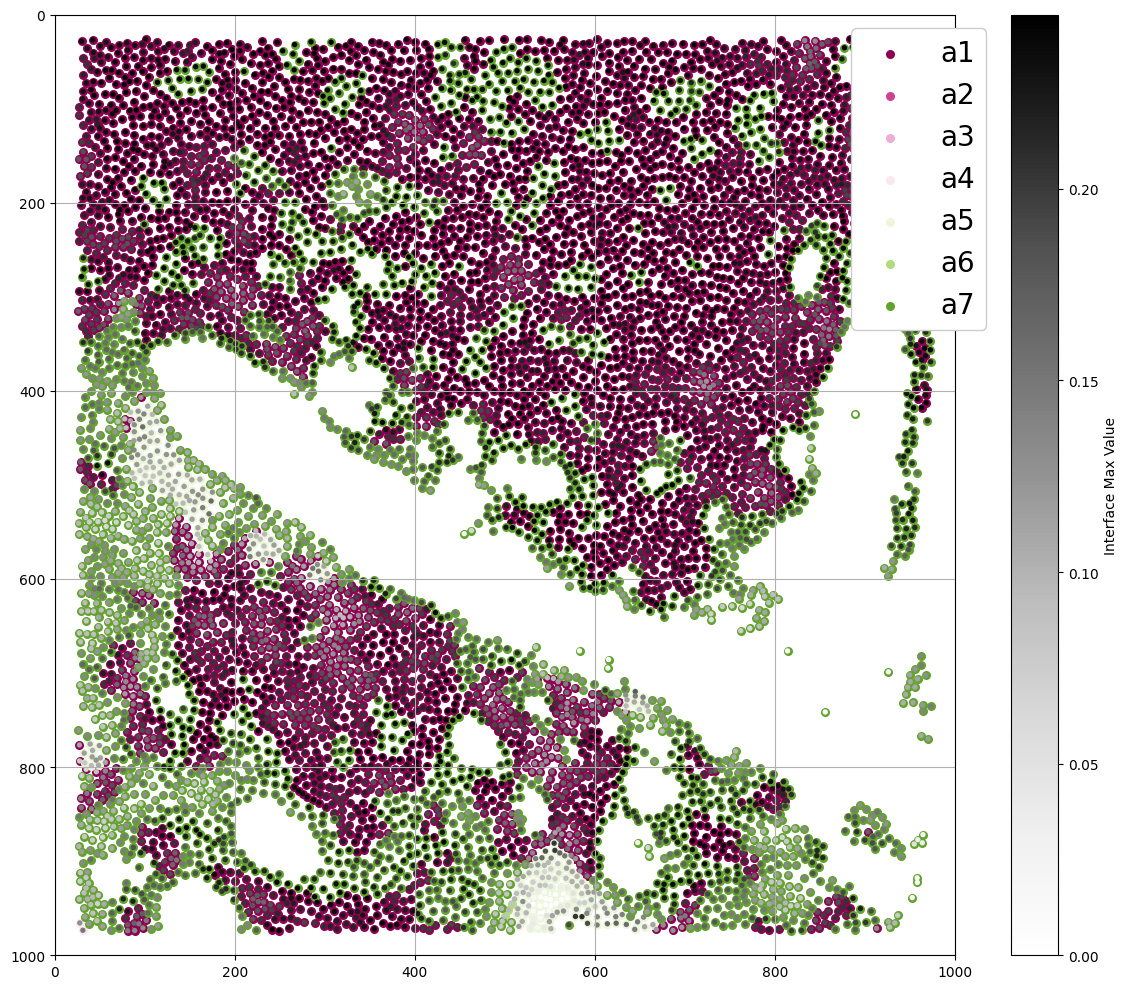

In [15]:
# plot cells using the coordinates, color each cell according to the niche it belongs to
# in addition plot interfaces in grayscale, plot only interface with weight higher than the threshold  
# this plot is done to see whether the cells with high interface values actually lay in between niches 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors

#specify the sample for plotting 
sample27 = data.loc[data['SampleID'] == 27]

output_directory = './7n_output/IMC20_B_001/'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  #change to another map like 'RdYlBu' if needed
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

quant = 0.99

#apply quantile threshold to max_interface_value
maxWeight = sample27['max_interface_value'].quantile(quant)
sample27.loc[sample27['max_interface_value'] > maxWeight, 'max_interface_value'] = maxWeight

#scatter plot for niches 
for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )

#normalise the interface values for opacity (larger values should have lower opacity)
norm = colors.Normalize(vmin=sample27['max_interface_value'].min(), vmax=sample27['max_interface_value'].max())

#scatter plot for interface values, using color and opacity
sc = plt.scatter(
    sample27['x'], 
    sample27['y'], 
    marker="o", 
    s=15,
    c=sample27['max_interface_value'], 
    cmap=plt.cm.get_cmap("Greys"),      
    alpha=1,                        
    edgecolor='none',
    norm=norm
)

cbar = plt.colorbar(sc, label='Interface Max Value')

plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

plt.savefig(os.path.join(output_directory, f'scatterplot_interface_greyscale_IMC20_B_001.png'), bbox_inches='tight')
plt.show()


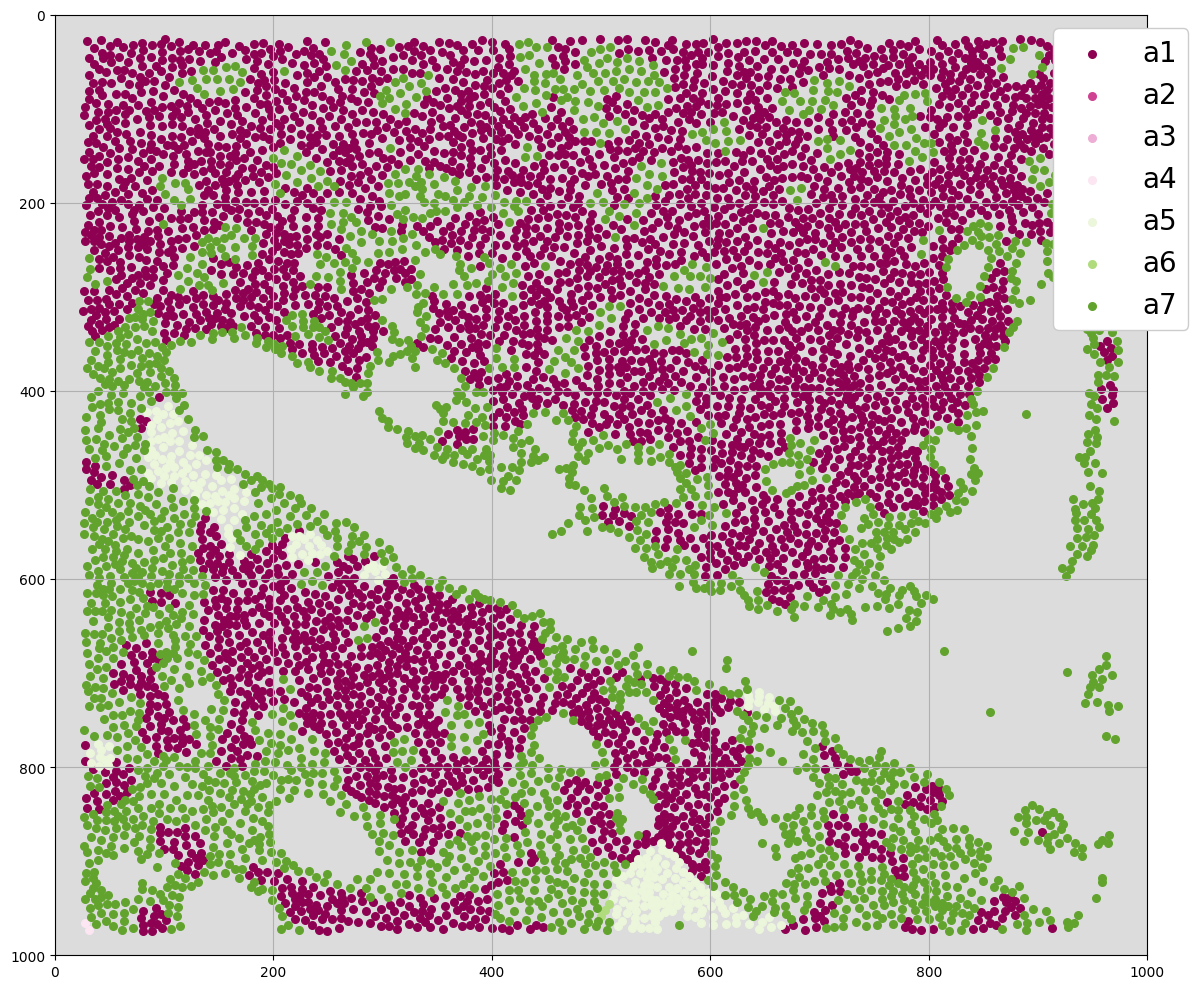

In [23]:
#plot just the niches, without any interfaces 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors

#specify the sample for plotting 
sample27 = data.loc[data['SampleID'] == 27]

output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")

#scatter plot for niches 
for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )

#this is needed to invert the plot 
plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'niches_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()

plt.show()


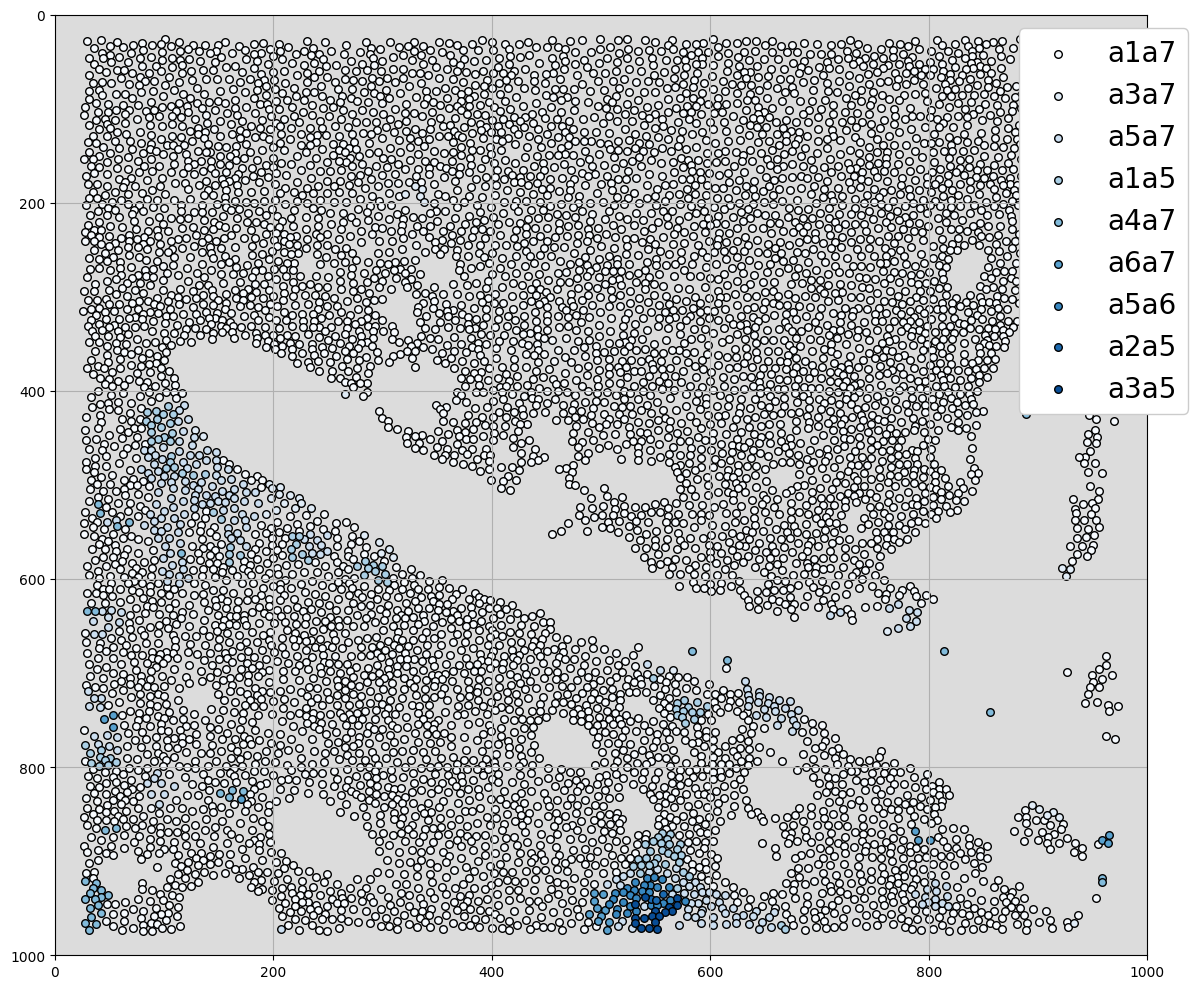

In [27]:
#plot interfaces of the specific sample 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors

#specify sample to be plotted 
sample27 = data.loc[data['SampleID'] == 27]

output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")

intf_columns = sample27['interface'].unique()
intf_cmap = plt.get_cmap('Blues') 
intf_colors = {intf: intf_cmap(i / len(intf_columns)) for i, intf in enumerate(intf_columns)}

for intf, color in intf_colors.items():
    intf_data = sample27[sample27['interface'] == intf]
    sc = plt.scatter(
        intf_data['x'], 
        intf_data['y'], 
        color=color, 
        label=intf,
        marker="o", s=30, edgecolors='black', linewidth=1
    )

plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

# Enable grid
plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'interfaces_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()

plt.show()


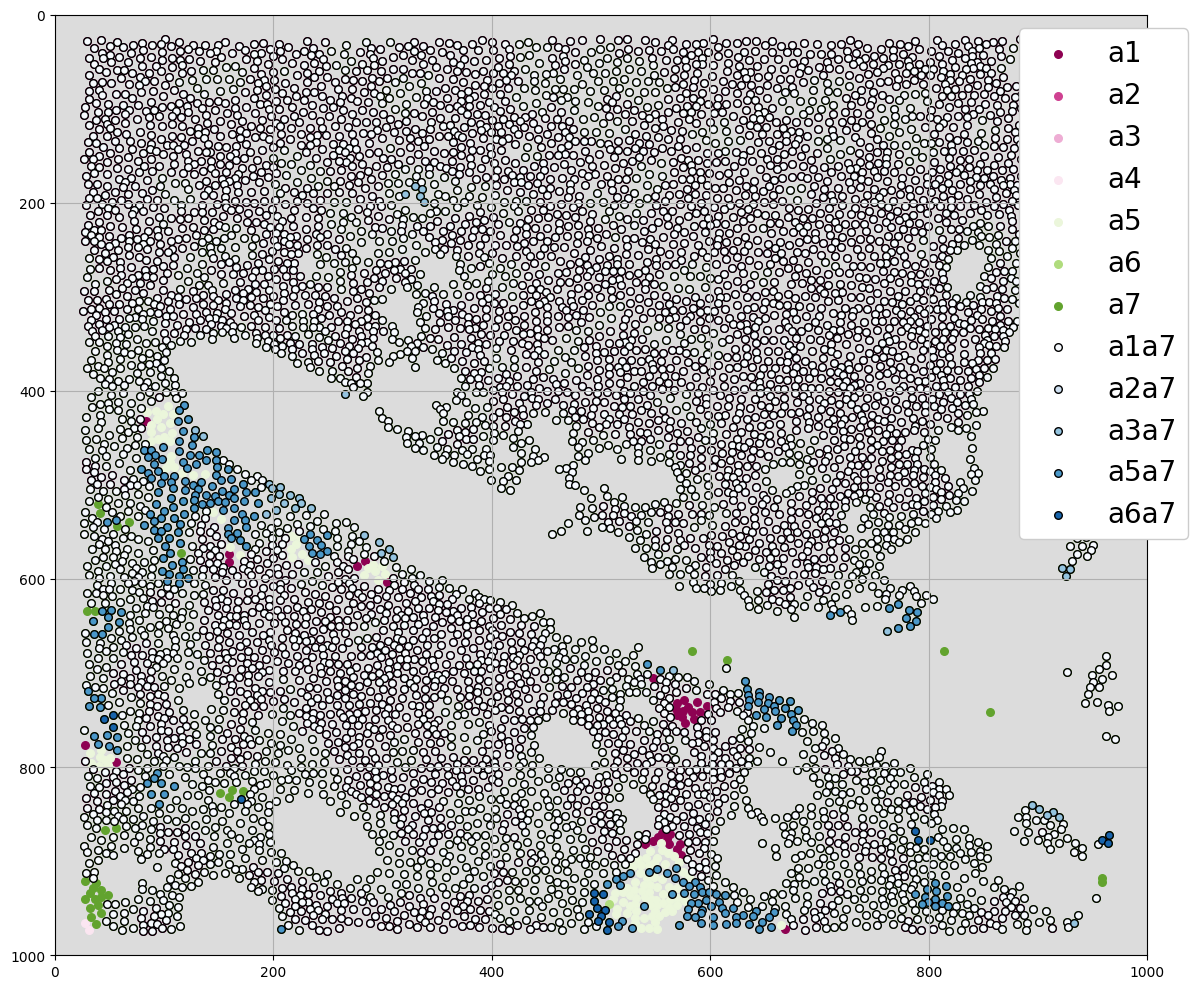

In [51]:
#plot just specific interfaces of a specific sample 


import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors
import scanpy as sc


#specify sample to be plotted 
sample27 = data.loc[data['SampleID'] == 27]


output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")


for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )

intf_columns = ['a1a7', 'a2a7', 'a3a7', 'a5a7', 'a6a7']
intf_cmap = plt.get_cmap('Blues') 
intf_colors = {intf: intf_cmap(i / len(intf_columns)) for i, intf in enumerate(intf_columns)}

for intf, color in intf_colors.items():
    intf_data = sample27[sample27['interface'] == intf]
    plt.scatter(
        intf_data['x'], 
        intf_data['y'], 
        color=color, 
        label=intf,
        marker="o", s=30, edgecolors='black', linewidth=1
    )


plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'niche7_interfaces_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()


plt.show()

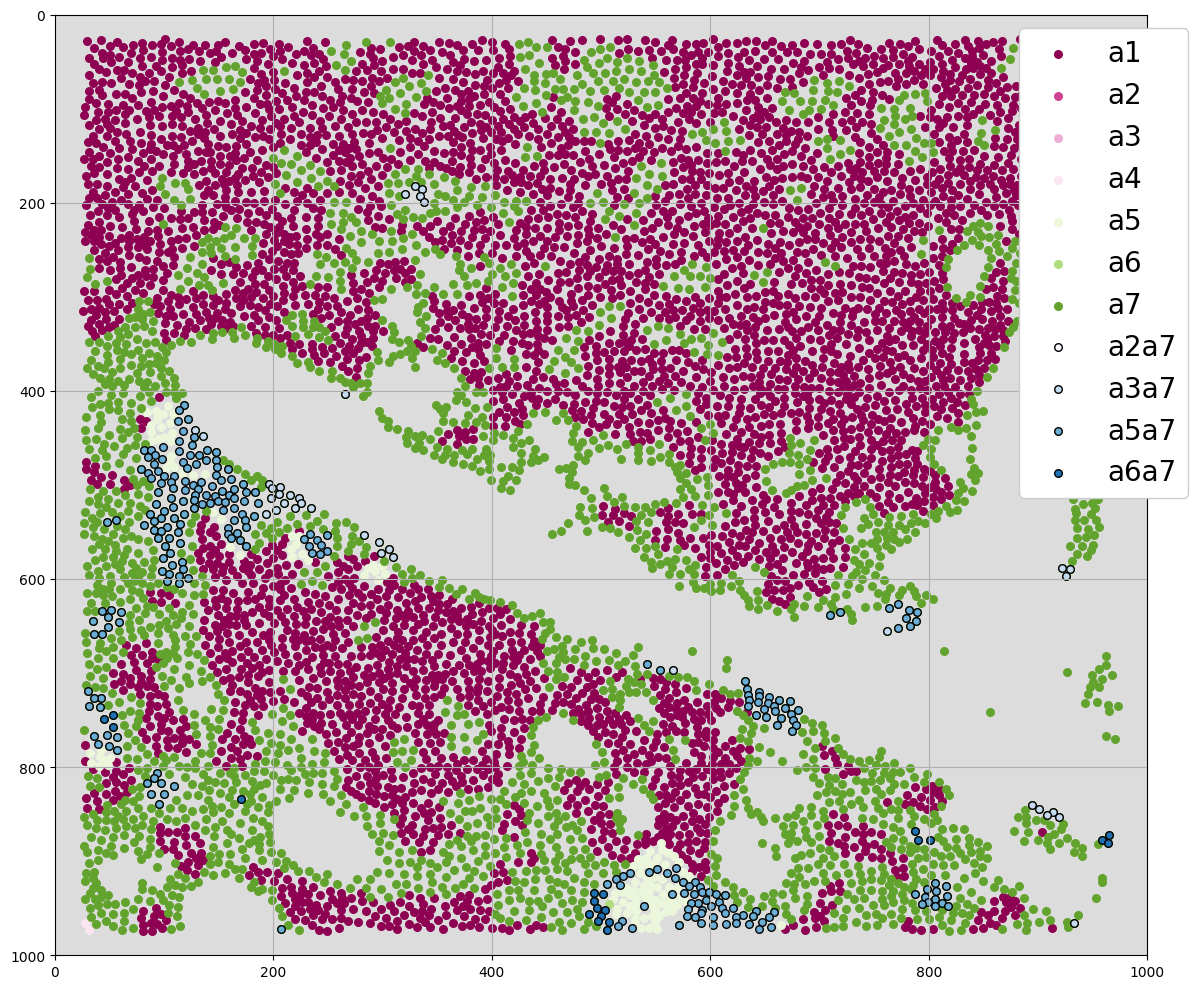

In [56]:
#plot just the interfaces of the niche 7 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors
import scanpy as sc


#specify sample to be plotted 
sample27 = data.loc[data['SampleID'] == 27]


output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")


for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )

intf_columns = ['a2a7', 'a3a7', 'a5a7', 'a6a7']
intf_cmap = plt.get_cmap('Blues') 
intf_colors = {intf: intf_cmap(i / len(intf_columns)) for i, intf in enumerate(intf_columns)}

for intf, color in intf_colors.items():
    intf_data = sample27[sample27['interface'] == intf]
    plt.scatter(
        intf_data['x'], 
        intf_data['y'], 
        color=color, 
        label=intf,
        marker="o", s=30, edgecolors='black', linewidth=1
    )


plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'niche7_interfaces_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()


plt.show()

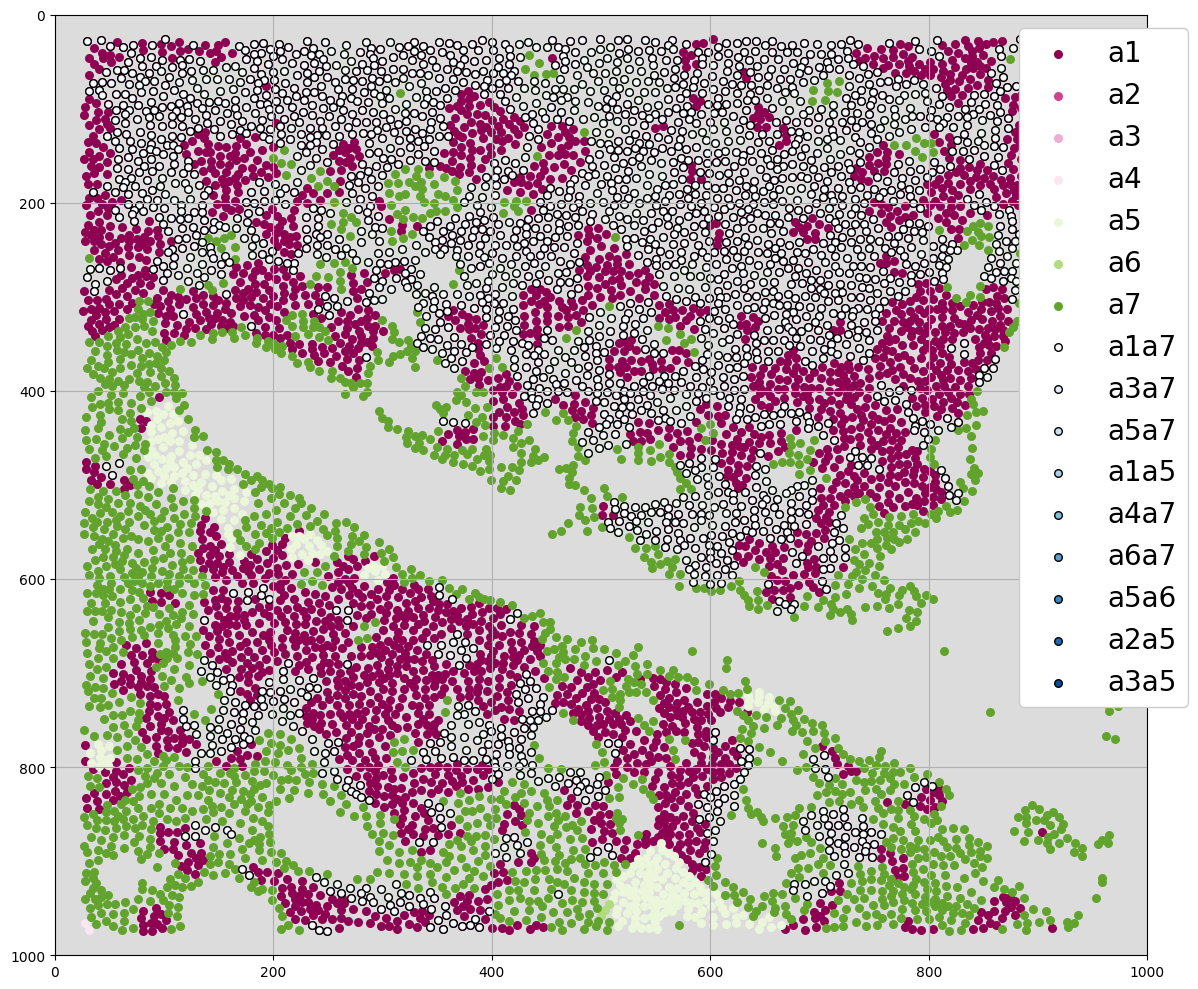

In [54]:
#plot the interfaces with a max value cutoff 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors

#specify sample to be plotted 
sample27 = data.loc[data['SampleID'] == 27]


output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")


for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )


intf_columns = sample27['interface'].unique()
intf_cmap = plt.get_cmap('Blues') 
intf_colors = {intf: intf_cmap(i / len(intf_columns)) for i, intf in enumerate(intf_columns)}

sample27_cutoff = sample27[sample27['max_interface_value'] > 0.23]

for intf, color in intf_colors.items():
    intf_data = sample27_cutoff[sample27_cutoff['interface'] == intf]
    plt.scatter(
        intf_data['x'], 
        intf_data['y'], 
        color=color, 
        label=intf,
        marker="o", s=30, edgecolors='black', linewidth=1
    )

plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'cutoff_intf_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()

plt.show()

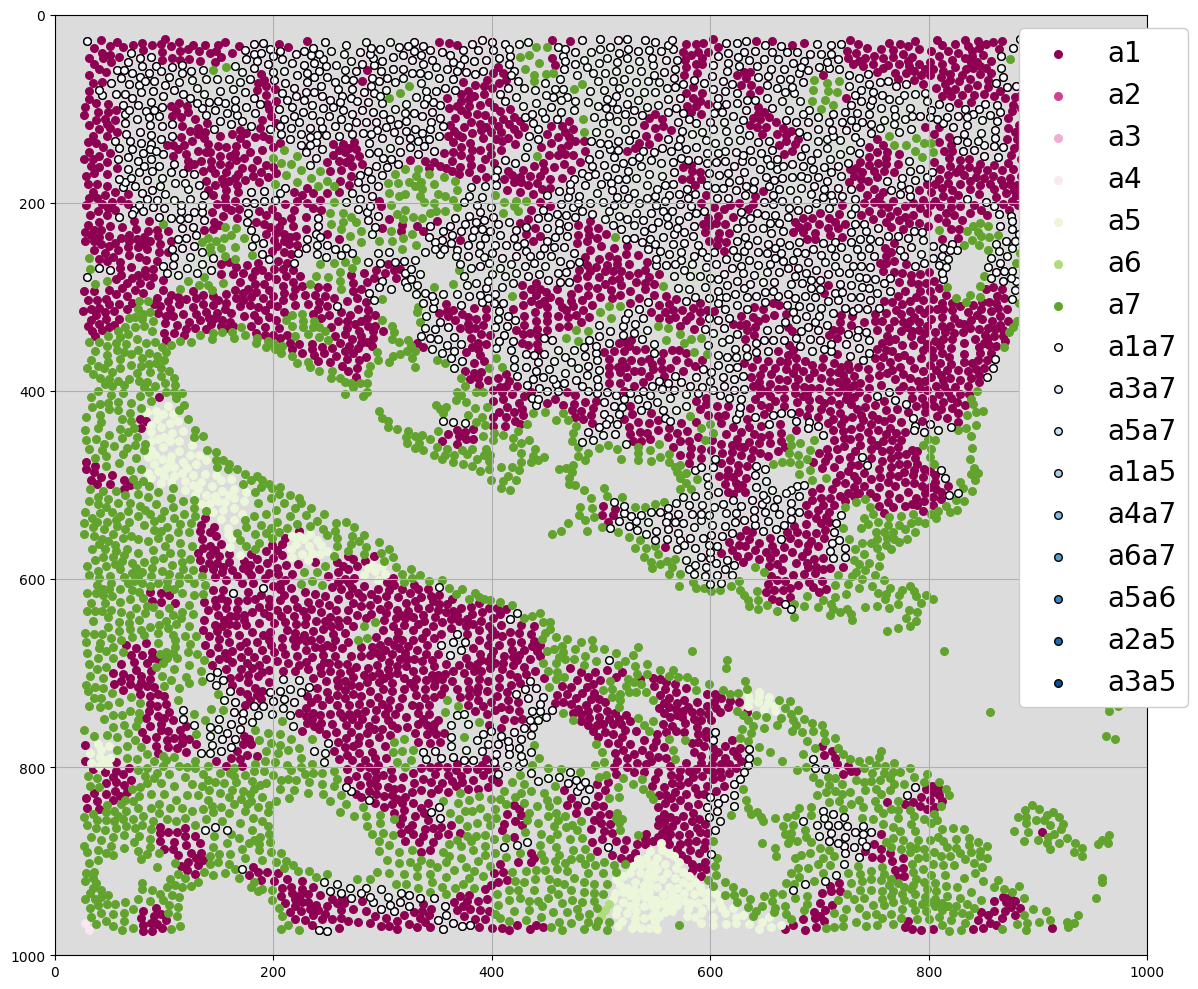

In [55]:
#plot only interfaces with a max value that lays in the upper quartile 

import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from matplotlib import colors

#specify sample to be plotted 
sample27 = data.loc[data['SampleID'] == 27]

output_directory = './7n_output/IMC20_B_001'
os.makedirs(output_directory, exist_ok=True)

plt.figure(figsize=(12, 10))

niche_cmap = plt.get_cmap('PiYG')  # Change to another map like 'RdYlBu' if needed
niche_colors = {niche: niche_cmap(i / len(niche_columns)) for i, niche in enumerate(niche_columns)}

ax = plt.axes()
ax.set_facecolor("gainsboro")


# Scatter plot for niches with fixed color
for niche, color in niche_colors.items():
    niche_data = sample27[sample27['niche'] == niche]
    plt.scatter(
        niche_data['x'], 
        niche_data['y'], 
        color=color, 
        label=niche,
        marker="o", s=30
    )


intf_columns = sample27['interface'].unique()
intf_cmap = plt.get_cmap('Blues') 
intf_colors = {intf: intf_cmap(i / len(intf_columns)) for i, intf in enumerate(intf_columns)}

sample27_sorted = sample27.sort_values(by = 'max_interface_value') 
upper25 = round(len(sample27_sorted['max_interface_value']) - len(sample27_sorted['max_interface_value'])/4)
sample27_upper25 = sample27_sorted[upper25:]

for intf, color in intf_colors.items():
    intf_data = sample27_upper25[sample27_upper25['interface'] == intf]
    sc = plt.scatter(
        intf_data['x'], 
        intf_data['y'], 
        color=color, 
        label=intf,
        marker="o", s=30, edgecolors='black', linewidth=1
    )

plt.xlim(0, 1000)
plt.ylim(1000, 0) 

plt.legend(facecolor='white', framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper right', fontsize="20")

plt.grid(True)

plt.tight_layout()

#plt.savefig(os.path.join(output_directory, f'upper25_intf_IMC20_B_001.png'), bbox_inches='tight')
#plt.close()

plt.show()

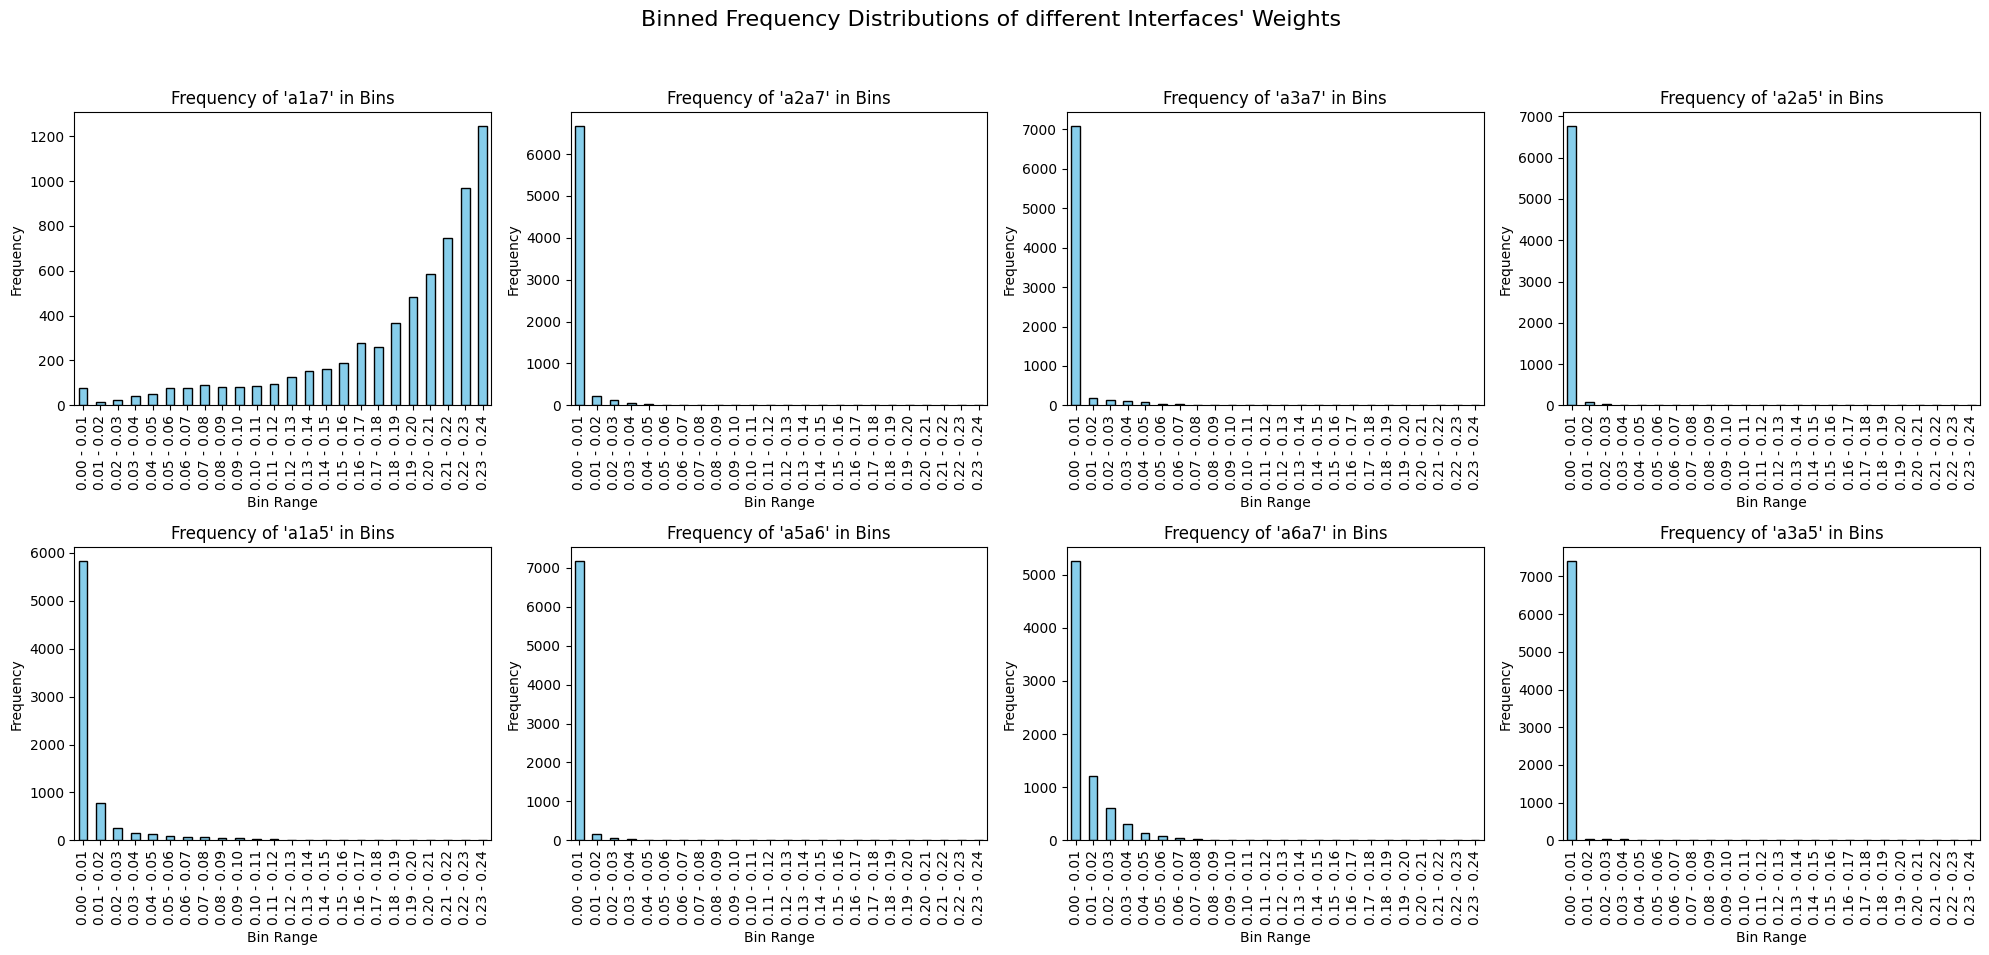

In [41]:
#plot the number of cells that are allocated to each of the interface and the max values. this shows nicely that some cells are just over-allocated to a certain interface and we need a cutoff value to control it 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

all_samples_data = pd.read_csv('./lukas_data/7n_output/cells_niches_coordinates_interfaces.csv')
sample27 = all_samples_data.loc[all_samples_data['SampleID'] == 27]
sample27 = sample27[['a1a7', 'a2a7', 'a3a7', 'a2a5', 'a1a5', 'a5a6', 'a6a7', 'a3a5']]

i_list = ['a1a7', 'a2a7', 'a3a7', 'a2a5', 'a1a5', 'a5a6', 'a6a7', 'a3a5']

bins = np.arange(0, 0.25, 0.01)  # Bins from 0.0 to 0.25 with 0.01 intervals
labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]

# Set up the figure with a 2x3 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns for 6 subplots
fig.suptitle("Binned Frequency Distributions of different Interfaces' Weights ", fontsize=16)

# Loop over columns in i_list and corresponding subplots
for i, (col, ax) in enumerate(zip(i_list, axs.flat)):
    # Bin the column values
    binned_values = pd.cut(sample27[col], bins=bins, labels=labels, include_lowest=True)
    # Count frequencies of values in each bin
    bin_counts = binned_values.value_counts().sort_index()
    
    # Plot the frequencies for this column in the current subplot
    bin_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f"Frequency of '{col}' in Bins")
    ax.set_xlabel("Bin Range")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Additional space at top for suptitle
plt.show()
